In [42]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import WMAP5

DP2_DIRECTORY = "/home/vibin/MyFolder/WorkDesk/DP2/"

In [43]:
def find_pi_rp(ra_col_schind_23, dec_col_schind_23, red_col_schind_23):
    dist_sq = np.square(np.array(Distance(z=red_col_schind_23)))
    v1_sq, v2_sq = np.meshgrid(dist_sq, dist_sq)

    ps1_quasars = SkyCoord(ra_col_schind_23*u.deg, dec_col_schind_23*u.deg, Distance(z=red_col_schind_23))
    ps1_quasars.representation_type = 'cartesian'
    
    x = np.array(ps1_quasars.x)
    y = np.array(ps1_quasars.y)
    z = np.array(ps1_quasars.z)
    x1, x2 = np.meshgrid(x, x)
    y1, y2 = np.meshgrid(y, y)
    z1, z2 = np.meshgrid(z, z)

    v1_v2 = x1*x2 + y1*y2 + z1*z2

    pi_array = np.absolute((v2_sq - v1_sq)/np.sqrt(v1_sq + v2_sq + 2 * v1_v2))
    rp_array = np.sqrt(np.absolute(v1_sq + v2_sq - 2 * v1_v2 - np.square(pi_array)))

    return pi_array, rp_array
    #return v1_sq, v2_sq, v1_v2

In [44]:
schind_23_file_name = DP2_DIRECTORY + "Data/apjaca7cat7_ascii.txt"
schind_23_data = open(schind_23_file_name, 'r')
ra_col_schind_23 = []
dec_col_schind_23 = []
red_col_schind_23 = []

skip_rows = 6
for line in schind_23_data:
    if (skip_rows > 0):
        skip_rows -= 1
        continue
    split_line = line.split()
    quasar_name = split_line[0] 
    red_col_schind_23.append(float(split_line[2]))
    ra_col_schind_23.append(float(quasar_name[4:13]))
    dec_col_schind_23.append(float(quasar_name[13:21]))
    

In [46]:
pi_array, rp_array = find_pi_rp(ra_col_schind_23, dec_col_schind_23, red_col_schind_23)

pi_array = pi_array[np.triu_indices(len(pi_array),k = 1)]
rp_array = rp_array[np.triu_indices(len(rp_array),k = 1)]

Text(0, 0.5, '$r_p$')

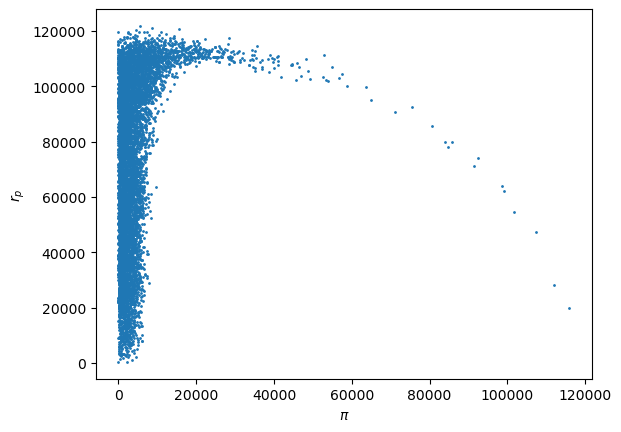

In [48]:
plt.scatter(pi_array, rp_array, s = 1)
plt.xlabel(r"$\pi$")
plt.ylabel(r"$r_p$")

### Here we are demonstrating that the shape of r_p vs pi graph is correct, by choosing a random distribution of objects in a 2d ring and calculating their r_p and pi.

In [49]:
def pi_fun(r1, r2, theta1, theta2):
    num = r2**2 - r1**2
    dinom = np.sqrt(r1**2 + r2**2 + 2 * r1 * r2 * np.cos(theta1 - theta2))
    return num/dinom

def rp_fun(r1, r2, theta1, theta2):
    num = r1**2 * r2**2 * (np.sin(theta1 - theta2))**2
    dinom = r1**2 + r2**2 + 2 * r1 * r2 * np.cos(theta1 - theta2)
    return 2 * np.sqrt(num/dinom)

In [62]:
r1 = 10000 + 10 * np.random.rand(1000)
r2, r1 = np.meshgrid(r1, r1)
theta1 = 2*np.pi * np.random.rand(1000)
theta2, theta1 = np.meshgrid(theta1, theta1)

v_pi_fun = np.vectorize(pi_fun)
v_rp_fun = np.vectorize(rp_fun)

pi_plot_array = pi_fun(r1, r2, theta1, theta2)
rp_plot_array = rp_fun(r1, r2, theta1, theta2)

pi_plot_array = pi_plot_array[np.triu_indices(len(pi_plot_array),k = 1)]
rp_plot_array = rp_plot_array[np.triu_indices(len(rp_plot_array),k = 1)]

Text(0, 0.5, '$r_p$')

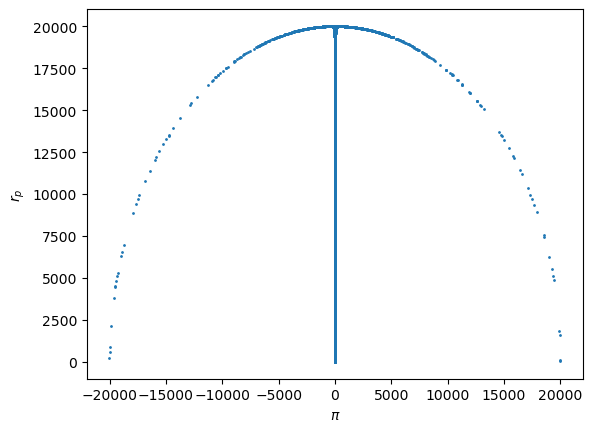

In [63]:
plt.scatter(pi_plot_array, rp_plot_array, s = 1)
plt.xlabel(r"$\pi$")
plt.ylabel(r"$r_p$")